In [3]:
import pandas as pd

# Read the datasets as single-column files without headers
coconut_df = pd.read_csv('unique_cleaned_coconut(absolute).txt', header=None)
lotus_df = pd.read_csv('lotus_cleaned.txt', header=None)
supernatural_df = pd.read_csv('supernatural_cleaned.txt', header=None)

# Combine datasets and drop duplicates
combined_df = pd.concat([coconut_df, lotus_df, supernatural_df]).drop_duplicates()

# Save the combined dataset to a new file without headers
combined_df.to_csv('combined_nps(absolute coconut).txt', index=False, header=False)

print("Combined dataset saved to 'combined_nps(absolute coconut).txt'")


Combined dataset saved to 'combined_nps(absolute coconut).txt'


In [4]:
count_df = pd.read_csv('combined_nps(absolute coconut).txt', header=None)
print(len(count_df))

1143594


In [8]:
import pandas as pd
from rdkit import Chem
from rdkit.Chem import Descriptors

# Load the data without column names and assign them
column_names = ['SMILES']
df = pd.read_csv('combined_nps(absolute coconut).txt', header=None, names=column_names)



# Add calculated columns if they are not present
if 'number_of_heavy_atoms' not in df.columns:
    df['number_of_heavy_atoms'] = df['SMILES'].apply(lambda x: Chem.MolFromSmiles(x).GetNumHeavyAtoms())

if 'molecule_weight' not in df.columns:
    df['molecule_weight'] = df['SMILES'].apply(lambda x: Descriptors.MolWt(Chem.MolFromSmiles(x)))

if 'smiles_string_length' not in df.columns:
    df['smiles_string_length'] = df['SMILES'].apply(len)

if 'number_of_chiral_centres' not in df.columns:
    df['number_of_chiral_centres'] = df['SMILES'].apply(lambda x: len(Chem.FindMolChiralCenters(Chem.MolFromSmiles(x), includeUnassigned=True)))

# Function to extract top 10% of data based on a column, ensuring no overlap
def extract_top_10_percent_no_overlap(df, column_name):
    threshold = df[column_name].quantile(0.9)
    top_10_percent_df = df[df[column_name] >= threshold]
    remaining_df = df[df[column_name] < threshold]
    return top_10_percent_df, remaining_df

# List of columns to consider
columns_of_interest = ['number_of_heavy_atoms', 'molecule_weight', 'smiles_string_length', 'number_of_chiral_centres']

top_10_percent_dfs = []
remaining_df = df.copy()

for column in columns_of_interest:
    top_10_percent_df, remaining_df = extract_top_10_percent_no_overlap(remaining_df, column)
    top_10_percent_dfs.append(top_10_percent_df)

# Combine the top 10% dataframes for each parameter
combined_top_10_percent_df = pd.concat(top_10_percent_dfs).reset_index(drop=True)

# Save the combined top 10% data to a CSV file
combined_top_10_percent_df.to_csv('top_10_percent_data.txt', index=False)

print("Combined top 10 percent data has been extracted and saved to 'top_10_percent_data.txt'.")


[15:20:31] WARNING: not removing hydrogen atom without neighbors
[15:23:36] WARNING: not removing hydrogen atom without neighbors
[15:27:42] WARNING: not removing hydrogen atom without neighbors


Combined top 10 percent data has been extracted and saved to 'top_10_percent_data.txt'.


In [1]:
import pandas as pd

# Load the data
input_file_path = 'top_10_percent_data.txt'
output_file_path = 'top_10_percent_data.txt'

# Read the data with a single unnamed column
df = pd.read_csv(input_file_path, delimiter='\t', header=None, names=['data'])

# Extract only the SMILES strings from the data
df['SMILES'] = df['data'].apply(lambda x: x.split(',')[0])

# Save the SMILES strings to a new file
df['SMILES'].to_csv(output_file_path, index=False, header=False)

print(f"SMILES strings have been extracted and saved to '{output_file_path}'")


SMILES strings have been extracted and saved to 'top_10_percent_data.txt'


[15:40:25] SMILES Parse Error: syntax error while parsing: SMILES
[15:40:25] SMILES Parse Error: Failed parsing SMILES 'SMILES' for input: 'SMILES'


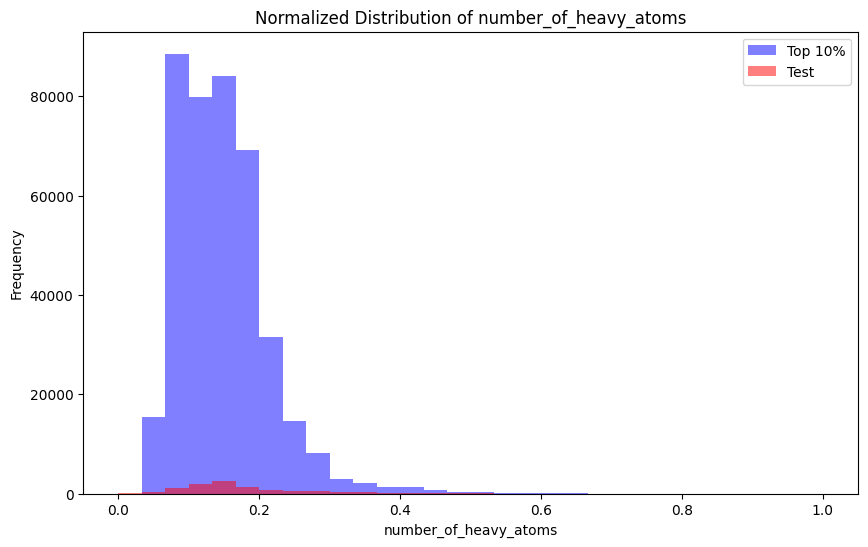

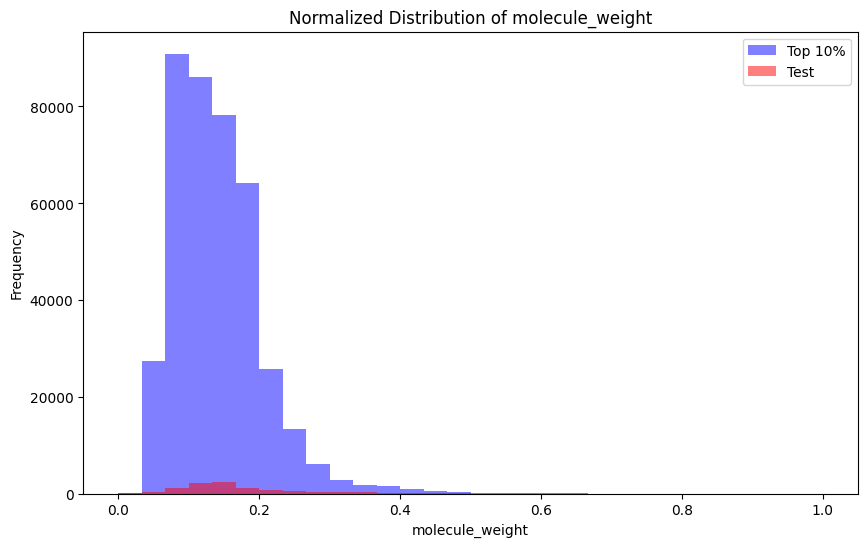

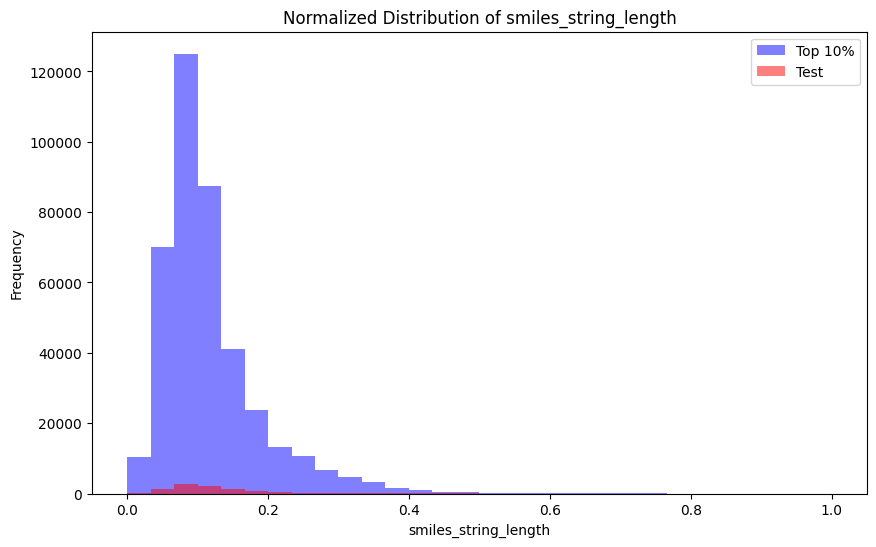

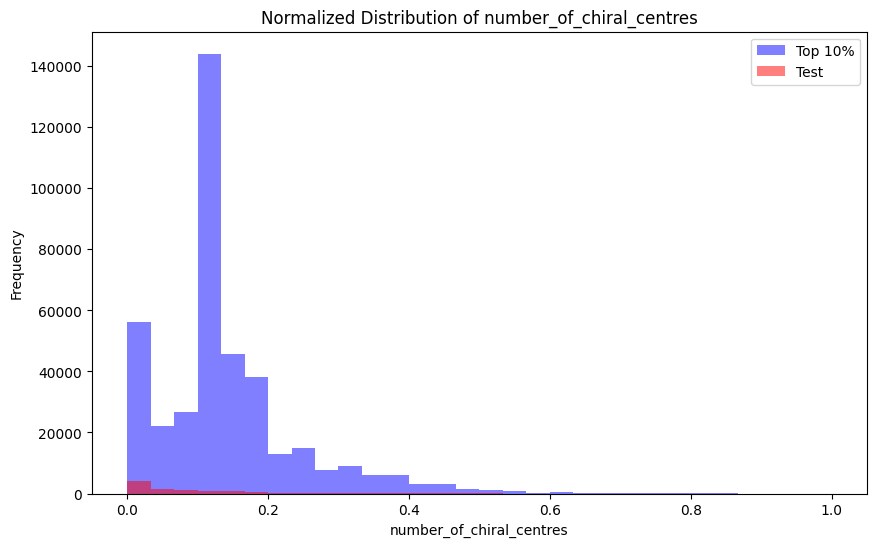

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from rdkit import Chem
from rdkit.Chem import Descriptors

# Load the data
top_10_percent_data_path = 'top_10_percent_data.txt'
test_data_path = 'test.txt'

# Read the data with a single unnamed column
top_10_df = pd.read_csv(top_10_percent_data_path, header=None, names=['SMILES'])
test_df = pd.read_csv(test_data_path, header=None, names=['SMILES'])

# Function to extract required features using RDKit
def extract_features(df):
    df['mol'] = df['SMILES'].apply(lambda x: Chem.MolFromSmiles(x))
    df = df[df['mol'].notna()].copy()  # Remove rows where mol is None
    df['number_of_heavy_atoms'] = df['mol'].apply(lambda x: x.GetNumHeavyAtoms())
    df['molecule_weight'] = df['mol'].apply(lambda x: Descriptors.MolWt(x))
    df['smiles_string_length'] = df['SMILES'].apply(len)
    df['number_of_chiral_centres'] = df['mol'].apply(lambda x: len(Chem.FindMolChiralCenters(x, includeUnassigned=True)))
    df.drop(columns=['mol'], inplace=True)
    return df

# Extract features for both datasets
top_10_df = extract_features(top_10_df)
test_df = extract_features(test_df)

# Specify the columns of interest
columns_of_interest = ['number_of_heavy_atoms', 'molecule_weight', 'smiles_string_length', 'number_of_chiral_centres']

# Normalize the data
scaler = MinMaxScaler()

top_10_df_normalized = pd.DataFrame(scaler.fit_transform(top_10_df[columns_of_interest]), columns=columns_of_interest)
test_df_normalized = pd.DataFrame(scaler.fit_transform(test_df[columns_of_interest]), columns=columns_of_interest)

# Plot the distributions
for column in columns_of_interest:
    plt.figure(figsize=(10, 6))
    plt.hist(top_10_df_normalized[column], bins=30, alpha=0.5, label='Top 10%', color='blue')
    plt.hist(test_df_normalized[column], bins=30, alpha=0.5, label='Test', color='red')
    plt.title(f'Normalized Distribution of {column}')
    plt.xlabel(column)
    plt.ylabel('Frequency')
    plt.legend()
    plt.show()
